# Monte Carlo Simulations

This code runs the MC simulations generated for our project entitled "Differential Machine Learning Approach for Calculating Deltas in the Heston Model" (Balderas, McClure, Yadav, 2023). First it is imperative to clone the repository [`PyStochasticVolatility` ](https://github.com/Dagalon/PyStochasticVolatility/tree/master) and to install the necessary dependencies. For the code to work, the repo must be the current working directory. It is also highly suggested to run this notebook on Google Colab to take advantage of the `numba-scipy` package. 

This notebook will generate .csv outputs of the respective option prices, deltas, gammas, and asset prices onto the cloned repo.


In [2]:
# make sure it is /content
import os 
os.getcwd()

# Mount Google Drive. 
# your .csv will be saved in your Google Drive root folder.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Clone Pystochastic Volatility repository and make sure it the current working directory. 
!git clone https://github.com/Dagalon/PyStochasticVolatility.git
%cd 'PyStochasticVolatility'

Cloning into 'PyStochasticVolatility'...
remote: Enumerating objects: 2172, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 2172 (delta 161), reused 143 (delta 75), pack-reused 1923
Receiving objects: 100% (2172/2172), 3.52 MiB | 18.18 MiB/s, done.
Resolving deltas: 100% (1421/1421), done.
/content/PyStochasticVolatility


In [4]:
# Installing  dependencies. 
!pip install numba-scipy
!pip install sobol_seq
# !pip install time 
# !pip install prettytable
# !pip install tabulate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires scipy>=1.8.0, but you have scipy 1.7.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Monte Carlo Code 

In [ ]:
### Master Project MC Code 
from MC_Engines.MC_Heston import Heston_Engine
from Instruments.EuropeanInstruments import EuropeanOption, TypeSellBuy, TypeEuropeanOption
from Tools import Types
from Tools import RNG
from prettytable import PrettyTable
from time import time
import numpy as np
from tqdm import tqdm
from tabulate import tabulate

### Initializations

epsilon = 1.1  # vol of vol 
k = 0.5 # rate of mean reversion 
rho = -0.9 # correlation parameter 
v0 = 0.05 # initial vol
theta = 0.05 # long term vol

# Creating vector of parameters. 

parameters = [k,
              theta,
              epsilon, 
              rho] 

T = 2 # time to maturity 

seed = 123456789

delta = 1.0 / 32.0 # time increment 
no_time_steps = int(T / delta) # number of time steps 
no_paths = 10000 # number of MC asset price paths to simulate 
notional = 1.0


### Spot and strike price 
lower = 70 # lower limit 
upper = 180 # upper limit 
num = 10000 # number of observations - change to 1,000 to generate smaller dataset
spots = np.linspace(lower, upper, num).reshape((-1, 1)) # Create an equally spaced interval of 10,000 points, ranging from 50 to 175.
strike = 120.0 # strike price 


# Random number generator. 
rnd_generator = RNG.RndGenerator(seed)

# Arrays to store results.
option_prices = np.zeros(num)
standard_errors = np.zeros(num)
deltas = np.zeros(num)
gammas = np.zeros(num)
asset_prices = np.zeros(num)

start_time = time()

### MONTE CARLO SIMULATIONS ###

# For every spot price, 
for i in tqdm(range(num)):

   # Extract spot price from the array.
    spot_price = spots[i][0]  

    # Initialize EuropeanOption class.
    european_option = EuropeanOption(strike, notional, TypeSellBuy.BUY, TypeEuropeanOption.CALL, spot_price, T)

    
    # Generate asset price paths.
    map_heston_output = Heston_Engine.get_path_multi_step(0.0, # initial time 
                                                          T, # time to maturity 
                                                          parameters, # vector of parameters 
                                                          spot_price, # spot price
                                                          v0, # initial vol
                                                          no_paths, # number of simulated asset paths 
                                                          no_time_steps, # number of time steps
                                                          Types.TYPE_STANDARD_NORMAL_SAMPLING.ANTITHETIC, # sampling method: antithetic sampling of standard normal 
                                                          rnd_generator)  
    
    # Get the option prices from asset paths.
    result = european_option.get_price(map_heston_output[Types.HESTON_OUTPUT.PATHS])
    
    # Compute delta and gamma using Malliavin calculus.
    malliavin_delta = european_option.get_malliavin_delta(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.DELTA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    malliavin_gamma = european_option.get_malliavin_gamma(map_heston_output[Types.HESTON_OUTPUT.PATHS],
                                                          map_heston_output[Types.HESTON_OUTPUT.GAMMA_MALLIAVIN_WEIGHTS_PATHS_TERMINAL])
    
    # Store results in arrays.
    option_prices[i] = result[0]
    standard_errors[i] = result[1]
    deltas[i] = malliavin_delta[0]
    gammas[i] = malliavin_gamma[0]
    asset_prices[i] = np.mean([sub_array[-1] for sub_array in map_heston_output[Types.HESTON_OUTPUT.PATHS]]) # Average of last value for 200,000 simulations of asset prices.

# Printing results. 
print("MC (Prices) and Malliavin method (Greeks).")
print("Options Prices:\n", option_prices)
print("Standard Errors:\n", standard_errors)
print("Deltas:\n", deltas)
print("Gammas:\n", gammas)
print("Asset Prices in First Time Period:\n", asset_prices)

end_time = time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

# Saving to CSV. 
np.savetxt("malliavin_option_prices_14.csv", option_prices, delimiter=",")
np.savetxt("malliavin_standard_errors_14.csv", standard_errors, delimiter=",")
np.savetxt("malliavin_deltas_14.csv", deltas, delimiter=",")
np.savetxt("malliavin_gammas_14.csv", gammas, delimiter=",")
np.savetxt("malliavin_asset_prices_14.csv", asset_prices, delimiter=",")

print("Results saved to CSV files.")


100%|██████████| 10000/10000 [1:37:08<00:00,  1.72it/s]


MC (Prices) and Malliavin method (Greeks).
Options Prices:
 [6.34956395e-04 1.88572543e-03 1.03508643e-03 ... 6.30710953e+01
 6.30875463e+01 6.34788590e+01]
Standard Errors:
 [0.00063494 0.00144609 0.00053785 ... 0.17536519 0.17485175 0.17293177]
Deltas:
 [9.47850914e-05 2.84037153e-04 3.57531714e-04 ... 9.69872898e-01
 9.69045594e-01 9.73293661e-01]
Gammas:
 [0.         0.         0.         ... 0.0009262  0.         0.00092649]
Asset Prices in First Time Period:
 [ 70.00668213  70.06097626  70.21012368 ... 179.35638936 179.28430158
 179.97196706]
Execution Time: 5828.408767461777 seconds
Results saved to CSV files.


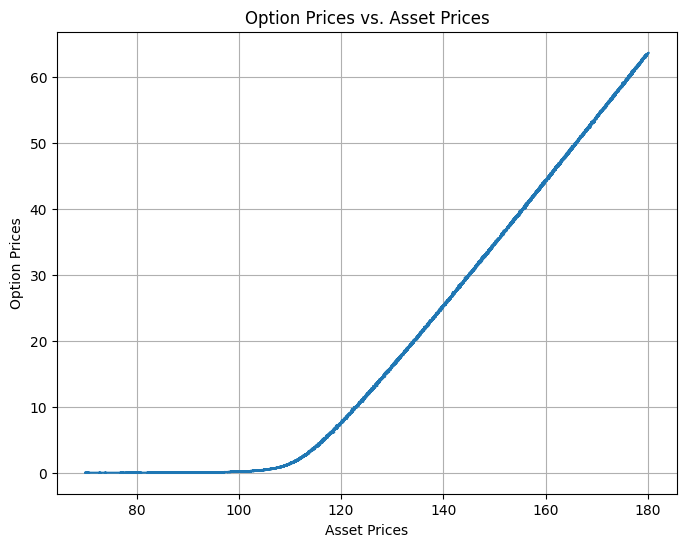

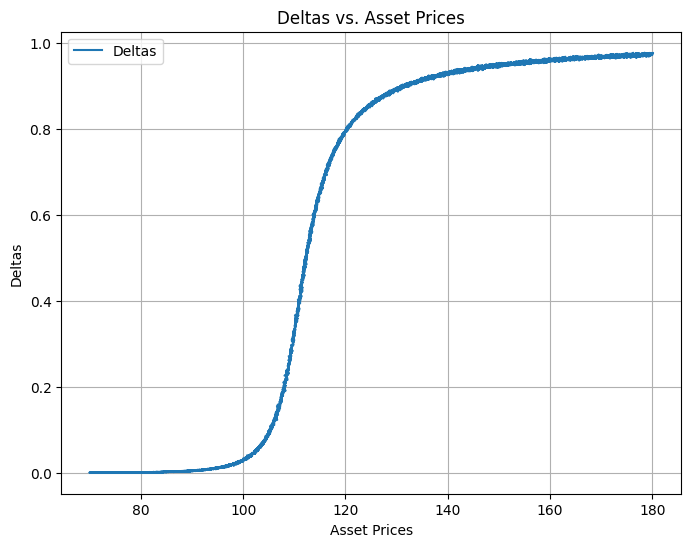

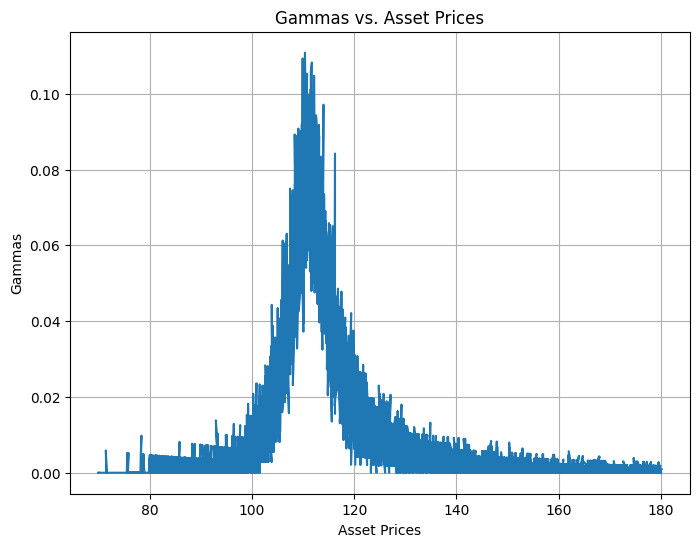

In [ ]:
### Plotting

import matplotlib.pyplot as plt 

# Plot option prices vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, option_prices)
plt.title('Option Prices vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Option Prices')
plt.grid(True)
plt.show()


# Plot deltas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, deltas,)
plt.title('Deltas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Deltas')
plt.grid(True)
plt.legend()  # Add legend to differentiate the lines
plt.show()


# Plot gammas vs. asset prices
plt.figure(figsize=(8, 6))
plt.plot(asset_prices, gammas)
plt.title('Gammas vs. Asset Prices')
plt.xlabel('Asset Prices')
plt.ylabel('Gammas')
plt.grid(True)
plt.show()